# Differential Expression Gene with BRICK

BRICK can be used to visualize the markers record in knowledge graph and reasoning the annotation result.

## Loading Packages and Data

In [17]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import BRICK

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

In [4]:
adata = sc.read('../KG_annotation/adata_new1.h5ad')
adata.X = adata.layers['lognorm'].copy()
sc.tl.rank_genes_groups(adata, groupby='KGannotator_refinement', pts=True)

adata

AnnData object with n_obs × n_vars = 822 × 14821
    obs: 'sample_name', 'n_genes', 'n_counts', 'annotation', 'leiden', 'KGannotator2', 'delta_specific', 'gamma_specific', 'leiden_combined', 'KGannotator_refinement'
    var: 'Ensembl_id', 'Symbol', 'NCBI_id', 'MGI_id', 'mean', 'std'
    uns: 'KGannotator2_colors', 'KGannotator_refinement_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'annotation_au'
    varm: 'PCs'
    layers: 'lognorm'
    obsp: 'connectivities', 'distances'

In [5]:
BRICK.pp.rank_genes_groups2df(adata)

In [102]:
## optional: use simple flavor to calculate logfoldchanges instead of scanpy
interval = 0.001


adata.var['mean_in'] = np.array(adata[adata.obs['KGannotator_refinement'] == 'pancreatic PP cell'].X.mean(axis=0))[0]
adata.var['mean_out'] = np.array(adata[adata.obs['KGannotator_refinement'] != 'pancreatic PP cell'].X.mean(axis=0))[0]
DEG_df['mean_in'] = adata.var['mean_in']
DEG_df['mean_out'] = adata.var['mean_out']
DEG_df['logfoldchanges'] = np.log2((DEG_df['mean_in']+interval) / (DEG_df['mean_out']+interval))

## Taking 'pancreatic PP cell' as example

In [39]:
select_group = 'pancreatic PP cell'
DEG_df = adata.uns['rank_genes_groups_df'][select_group]
DEG_df.head()

,names,scores,pvals,pvals_adj,logfoldchanges,pts,pts_rest,x,y
names,,,,,,,,,
Pcsk2,Pcsk2,18.791946,5.048756e-19,2.876849e-17,-0.080681,1.00,0.700748,-0.080681,18.296816
Pyy,Pyy,14.531603,4.579082e-12,9.085217e-11,-1.181229,1.00,0.714464,-1.181229,11.339222
Ppy,Ppy,8.546126,5.788614e-08,6.003712e-07,-0.497038,1.00,0.874065,-0.497038,7.237425
Peg3,Peg3,7.407349,3.735858e-07,3.378228e-06,-3.075948,1.00,0.405237,-3.075948,6.427610
Pcsk1n,Pcsk1n,7.395367,3.162213e-07,2.894821e-06,-5.166256,0.95,0.620948,-5.166256,6.500009


## query BRICK

query BRICK to get markers of prior knowledge for pancreatic PP cell

In [44]:
query_df = BRICK.qr.query_neighbor([select_group], source_entity_type='Cell', target_entity_type='Gene', relation='marker_of')
query_df = query_df.loc[query_df['path.2.name'].isin(adata.var_names)]
query_df.head(3)

,path.0.def,path.0.id,path.0.name,path.0.synonym,path.0.type,path.1,path.1.condition,path.1.info_source,path.1.info_source_length,path.1.original_relation,path.1.relation,path.1.relation_confidence,path.2.def,path.2.id,path.2.name,path.2.synonym,path.2.type
0,A PP cell located in the islets of the pancrea...,CL:0002275,pancreatic PP cell,pancreatic polypeptide-secreting cell|PP cell ...,Cell,marker_of,[UBERON:0001264],[SCT000000966],1,[DEG_of],marker_of,[0.506],zinc finger CCCH type containing 7B<loc>:15 E1...,NCBI:20286,Zc3h7b,Gm627|Scrg3|Zc2h7b|mKIAA1031,Gene
2,A PP cell located in the islets of the pancrea...,CL:0002275,pancreatic PP cell,pancreatic polypeptide-secreting cell|PP cell ...,Cell,marker_of,[UBERON:0001264],[SCT000000966],1,[DEG_of],marker_of,[0.503],complexin 2<loc>:13 B1|13 28.59 cM<xref>ENSEMB...,NCBI:12890,Cplx2,921-L|Gm34843,Gene
4,A PP cell located in the islets of the pancrea...,CL:0002275,pancreatic PP cell,pancreatic polypeptide-secreting cell|PP cell ...,Cell,marker_of,"[UBERON:0001911, UBERON:0001981, UBERON:000126...",[SCT000000793],1,[DEG_of],marker_of,[0.9089999999999999],"zinc finger, DBF-type containing 2<loc>:1|1 C2...",NCBI:73884,Zdbf2,4930431J08Rik|9330107J05Rik,Gene


## visualize markers of prior knowledge in volcano plot

(0.0, 12.0)

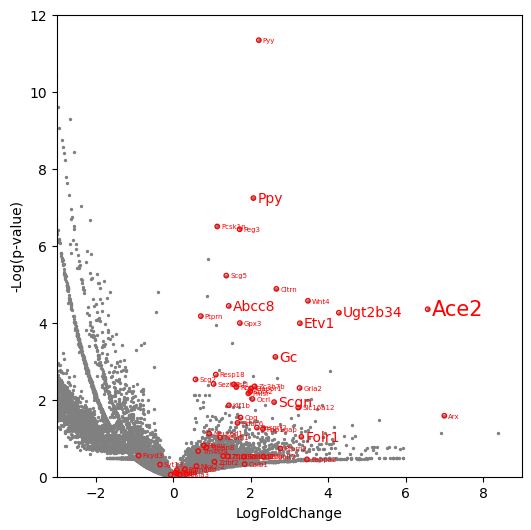

In [116]:
DEG_df['x'] = DEG_df['logfoldchanges']
DEG_df['y'] = -1 * np.log10(DEG_df['pvals'])


query_df.index = query_df['path.2.name']
for key in ['x', 'y']:
    query_df[key] = DEG_df[key]


fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(DEG_df['x'], DEG_df['y'], s = 2, color = 'grey')

ax.scatter(query_df['x'], query_df['y'], s = 10, facecolors='none', color = 'Red')

for _, row in query_df.iterrows():
    ax.text(row['x']+0.1, row['y'], row['path.2.name'], fontsize=row['path.1.info_source_length'] * 5, color='red', va='center') 


ax.set_xlabel('LogFoldChange')
ax.set_ylabel('-Log(p-value)')


ax.set_xlim([-3, 9])
ax.set_ylim([0, 12])

In [121]:
fig.savefig('d:/知识图谱文章/Figures/subplot/PP_cell_DEG_volcano.pdf')

## 